# SNR Distribution

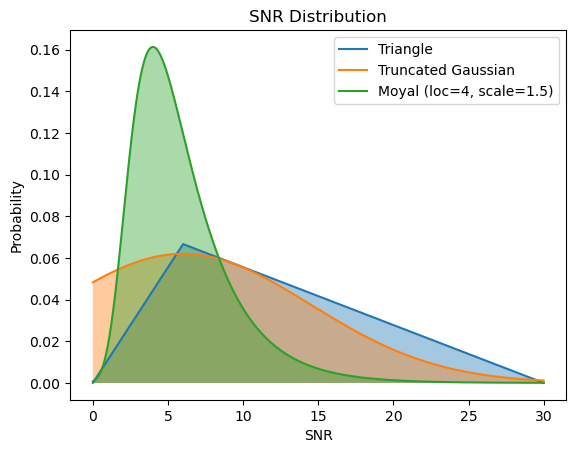

In [14]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

x = np.linspace(0,30,1000)
mode=6

# Triangle
left=0
right=30
c = (mode - left) / (right - left)
loc = left
scale_t = right - left
triangle = stats.triang.pdf(x, c=c, loc=loc, scale=scale_t)

# Gaussian
FWHM = 20
scale_g = FWHM / (2*np.sqrt(2*np.log(2)))
a, b = (0 - mode) / scale_g, (30 - mode) / scale_g
gaussian = stats.truncnorm.pdf(x, loc=mode, scale=scale_g, a=a, b=b)

# Mielke
mielke = stats.mielke.pdf(x, k=15, s=1.2, loc=.2, scale=1)

# Landau
moyal = stats.moyal.pdf(x, loc=4, scale=3/2)

plt.plot(x, triangle, label="Triangle")
plt.fill_between(x, triangle, alpha=0.4)
plt.plot(x, gaussian, label="Truncated Gaussian")
plt.fill_between(x, gaussian, alpha=0.4)
plt.plot(x, moyal, label="Moyal (loc=4, scale=1.5)")
plt.fill_between(x, moyal, alpha=0.4)
plt.xlabel("SNR")
plt.ylabel("Probability")
plt.title("SNR Distribution")
plt.legend()
plt.show()

# Galaxy Distributions

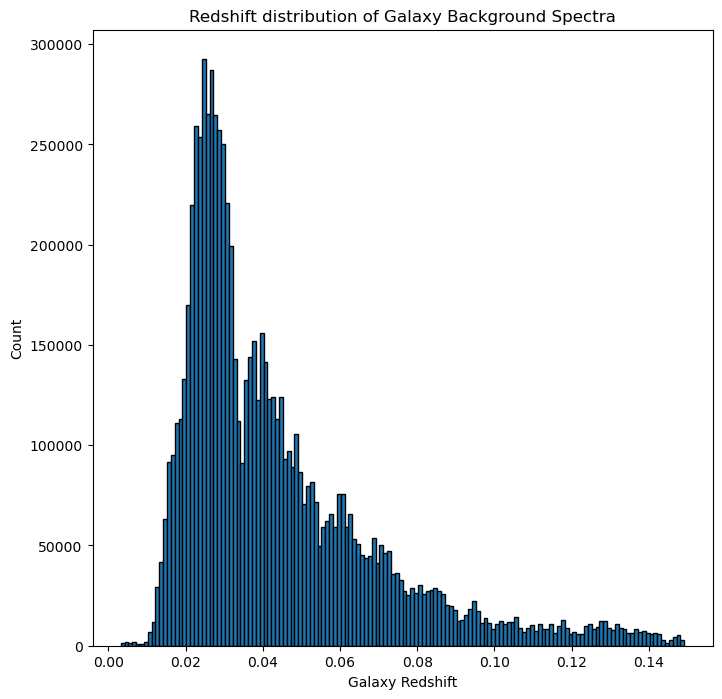

In [70]:
import config 
import matplotlib.pyplot as plt
import numpy as np

counts = np.load("../docs/galaxy_distribution.npy")
redshift_bins = np.round(np.arange(config.z_min, config.z_max, config.dz), 4)

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(x=redshift_bins, height=counts, width=config.dz, align="center", edgecolor="k")
plt.xlabel("Galaxy Redshift")
plt.ylabel("Count")
plt.title("Redshift distribution of Galaxy Background Spectra")
plt.show()

Keep as a box distribution as not to limit search capability

# Redshift Ratio

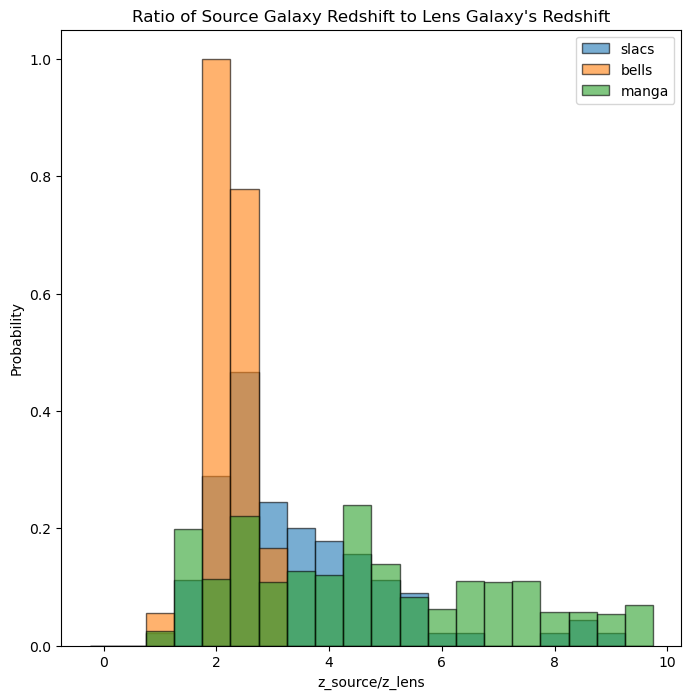

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import numpy as np
import os

plt.rcParams["figure.figsize"] = (8,8)

bells = pd.read_table("../bells.tsv")
slacs = pd.read_table("../slacs.tsv")
bells.columns = [name.replace("\"", "").strip() for name in bells.columns]
slacs.columns = [name.replace("\"", "").strip() for name in slacs.columns]

manga_detections = fits.open("../silo_manga_detections-1.0.3.fits")["detections"].data
manga = pd.DataFrame({"z_source": manga_detections.DETECTION_Z, "z_lens": manga_detections.FOREGROUND_Z})

bells["ratio"] = bells.z_source / bells.z_lens
slacs["ratio"] = slacs.z_source / slacs.z_lens
manga["ratio"] = manga.z_source / manga.z_lens

step=1/2

plt.hist(slacs.ratio, label="slacs", bins=np.arange(0-step/2,10,step), edgecolor='black', alpha=0.6, density=True, align="mid")
plt.hist(bells.ratio, label="bells", bins=np.arange(0-step/2,10,step), edgecolor='black', alpha=0.6, density=True, align="mid")
plt.hist(manga.ratio, label="manga", bins=np.arange(0-step/2,10,step), edgecolor='black', alpha=0.6, density=True, align="mid")

plt.legend()
plt.xlabel("z_source/z_lens")
plt.ylabel("Probability")
plt.title("Ratio of Source Galaxy Redshift to Lens Galaxy's Redshift")
plt.show()

Manga Lenses are much closer than slacs & bells --> Wider Einstein radius
- Selection Effect: instruments have built in selection (E_r <= fiber width)
- SLACS & BELLS cant have anything larger than 1 arcsecond
- MaNGA has up to 127 fibers --> Less selection 

Use this result to inform training

# "Poster Child" vs Synthetic

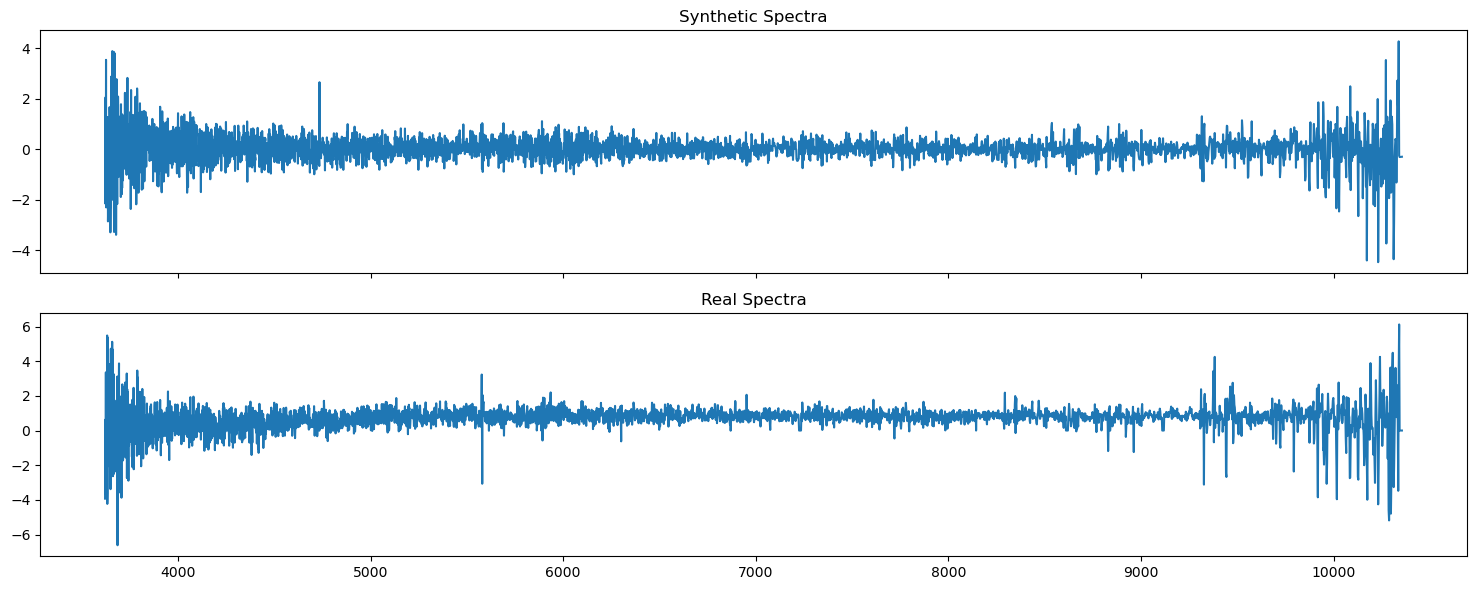

In [5]:
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import numpy as np
import config

def get_random_spectra():
    path = "./training_data/data/"
    folder = np.random.choice(os.listdir(f"./training_data/data/"), size=1)[0]
    file = np.random.choice(os.listdir(f"./training_data/data/{folder}"), size=1)[0]
    dataset = pd.read_parquet(os.path.join(path, folder, file))
    idx = np.random.randint(len(dataset.spectra))
    random_spectra = {"spectra": dataset.spectra[idx], "labels": dataset.labels[idx]}
    return (random_spectra, folder)

poster_child = fits.open("../manga-8606-6102-LOGRSS.fits.gz")
fluxs = poster_child["FLUX"].data

spectra, folder = get_random_spectra()
labels = spectra["labels"]
plt.rcParams["figure.figsize"] = (15, 3*2)

figs, axs = plt.subplots(nrows = 2, ncols=1, sharex=True, tight_layout=True)

# axs[0].set_title(f"Synthetic Spectra:\n{config.all_names}\n{labels}")
axs[0].set_title(f"Synthetic Spectra")
axs[0].plot(config.manga_wave, spectra["spectra"])

axs[1].plot(config.manga_wave, fluxs[101])
axs[1].set_title("Real Spectra")

plt.show()

# Emission Line Widths

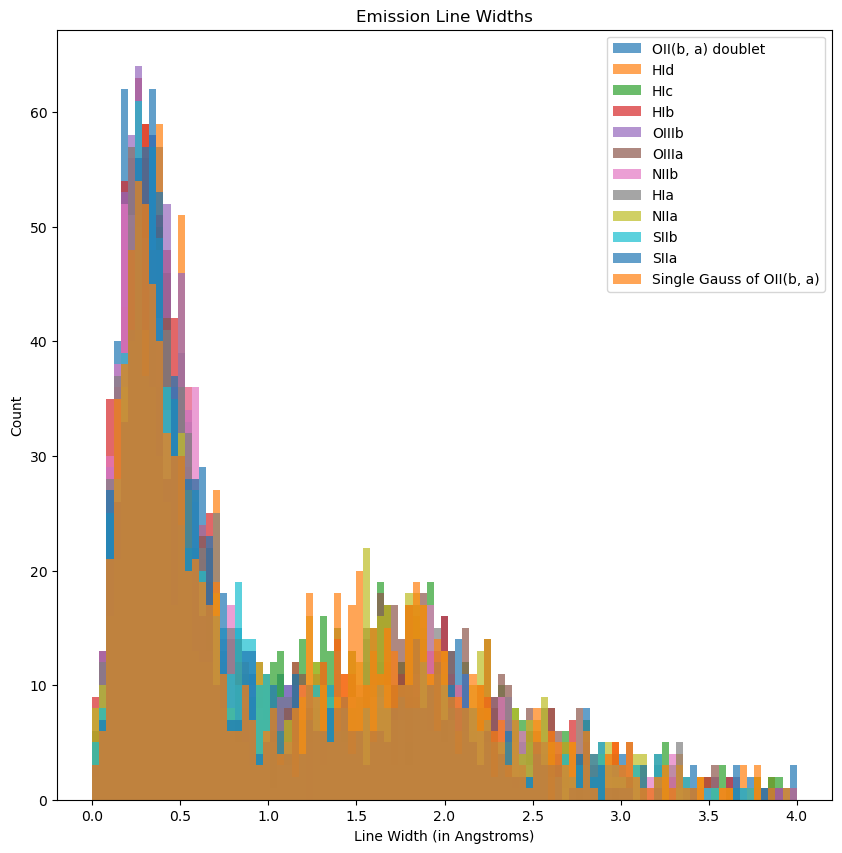

In [2]:
from astropy.io import fits
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
import pandas as pd

def remove_emptys(lst: list):
    return np.array([x for x in lst if len(x) > 0])
	
manga_wave = np.load("../manga_wave.npy")

real_lines = fits.open("../silo_manga_detections-1.0.3.fits")
# real_lines.info()

line_names = real_lines["EMISSION_LINE_ANALYSIS"].data["NAME"]
wavelengths = real_lines["EMISSION_LINE_ANALYSIS"].data["MODEL_WAVE_BASE"]
fluxs = real_lines["EMISSION_LINE_ANALYSIS"].data["GAUSS_MODEL"]
sigmas = real_lines["EMISSION_LINE_ANALYSIS"].data["GAUSS_SIGMA"]
sigmas = sigmas[sigmas != -9999.0]

def insert_to_manga(flux: ndarray, wavelengths: ndarray) -> ndarray:
    try:
        start = np.where(manga_wave == manga_wave[np.abs(manga_wave - wavelengths[0]).argmin()])[0][0]
        stop = np.where(manga_wave == manga_wave[np.abs(manga_wave - wavelengths[-1]).argmin()])[0][0]
    except:
        return np.zeros_like(manga_wave)

    beginning = np.zeros(start-1)
    ending = np.zeros(manga_wave.shape[0] - stop)
    
    return np.concatenate((beginning, flux, ending))


def get_snr(signal):
    signal = np.asanyarray(signal)
    mean = signal.mean(0)
    std = signal.std(axis=0, ddof=0)
    return np.where(std == 0, 0, mean/std)


data = pd.DataFrame(columns=["flux", "sigma"], index=line_names[0:12])
for name in line_names[0:12]:
    flux = remove_emptys(fluxs[np.where(line_names == name)])
    wave = remove_emptys(wavelengths[np.where(line_names == name)])
    sigma = sigmas[np.where(line_names == name)]
    # flux = fluxs[np.where(line_names == name)]
    # wave = wavelengths[np.where(line_names == name)]
    temp = [insert_to_manga(f, w) for w, f in zip(wave, flux)]
    
    data.flux.loc[name] = temp
    data.sigma.loc[name] = np.abs(sigma)

data.head()


plt.rcParams["figure.figsize"] = (10, 10)
plt.title("Emission Line Widths")
for i, sigmas in enumerate(data.sigma):
    plt.hist(sigmas, bins=np.linspace(0,4,100), label=data.index[i], alpha=0.7)

plt.xlabel("Line Width (in Angstroms)")
plt.ylabel("Count")
plt.legend()
plt.show()